In [1]:
import cv2
import numpy as np

%matplotlib inline

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]  # Make inline plots larger

## Image Transformations

### Resizing

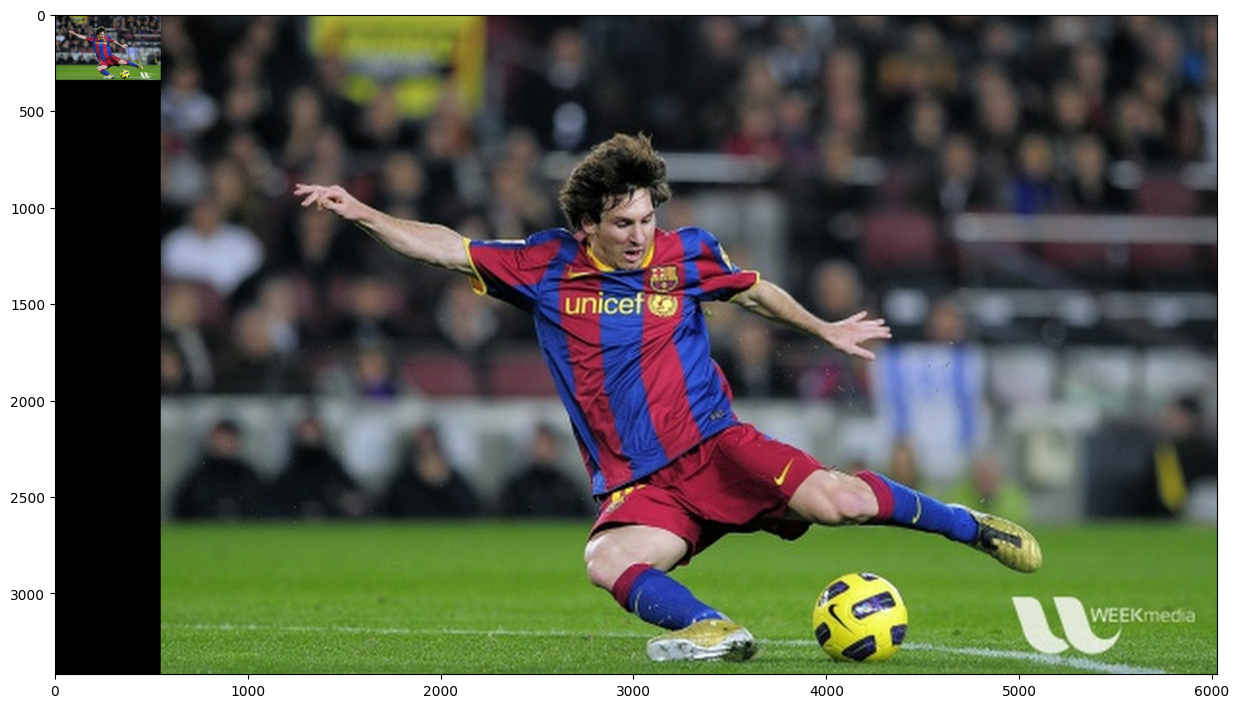

In [2]:
scalefactor=10

messi = plt.imread('data/messi.jpg')

#the heart of the code:
res = cv2.resize(messi,None,fx=scalefactor, fy=scalefactor,
                 interpolation = cv2.INTER_LANCZOS4)

#the remainder of the code is to generate the display image
height, width = messi.shape[:2]

bigwidth = int( np.amax( [scalefactor*height , height]) )
bigheight = int( width*(1+scalefactor))

bigim = np.zeros((bigwidth , bigheight ,3), np.uint8)
bigim[:height,:width] = messi

if scalefactor > 1:
    bigim[:,width:] = res
else:
    bigim[: int(scalefactor*height),width:] = res

plt.figure()
plt.imshow(bigim)

### Translation

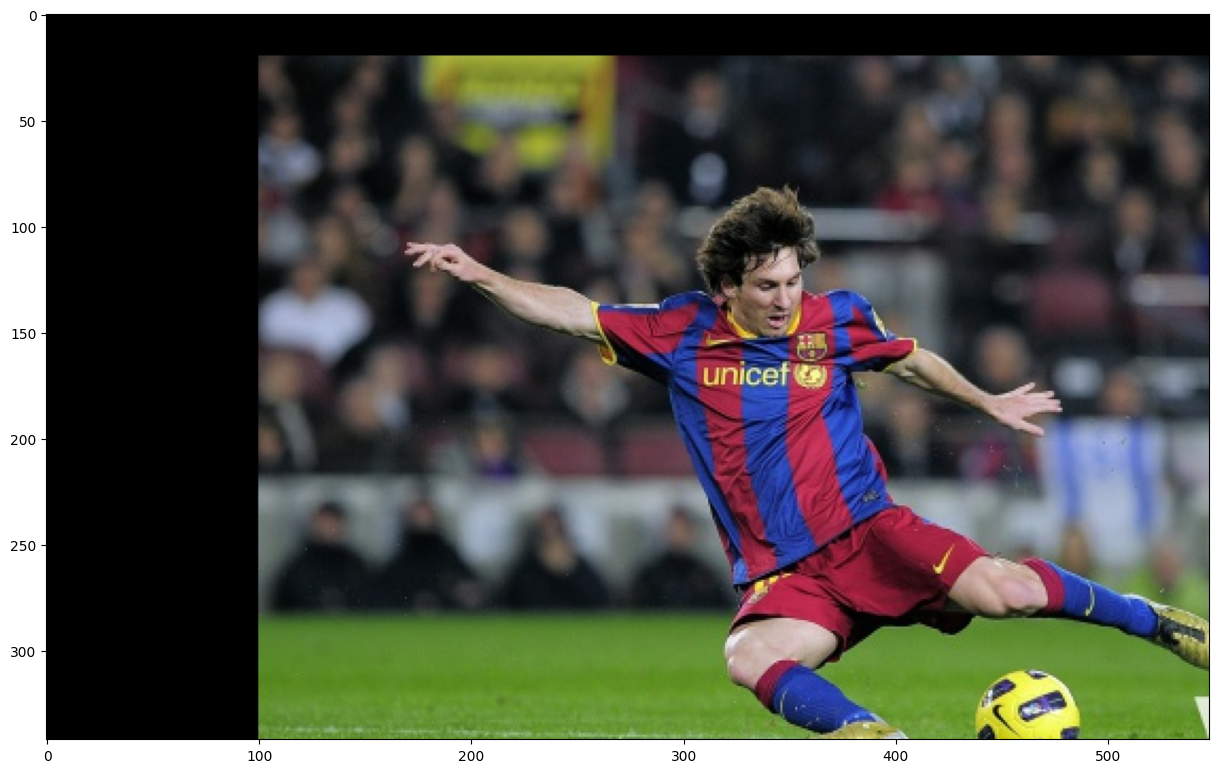

In [3]:
rows,cols,chans = messi.shape

xshift=100
yshift=20

M = np.float32([[1,0,xshift],[0,1,yshift]])
dst = cv2.warpAffine(messi, M,(cols,rows))

plt.figure()
plt.imshow(dst)

### Rotation

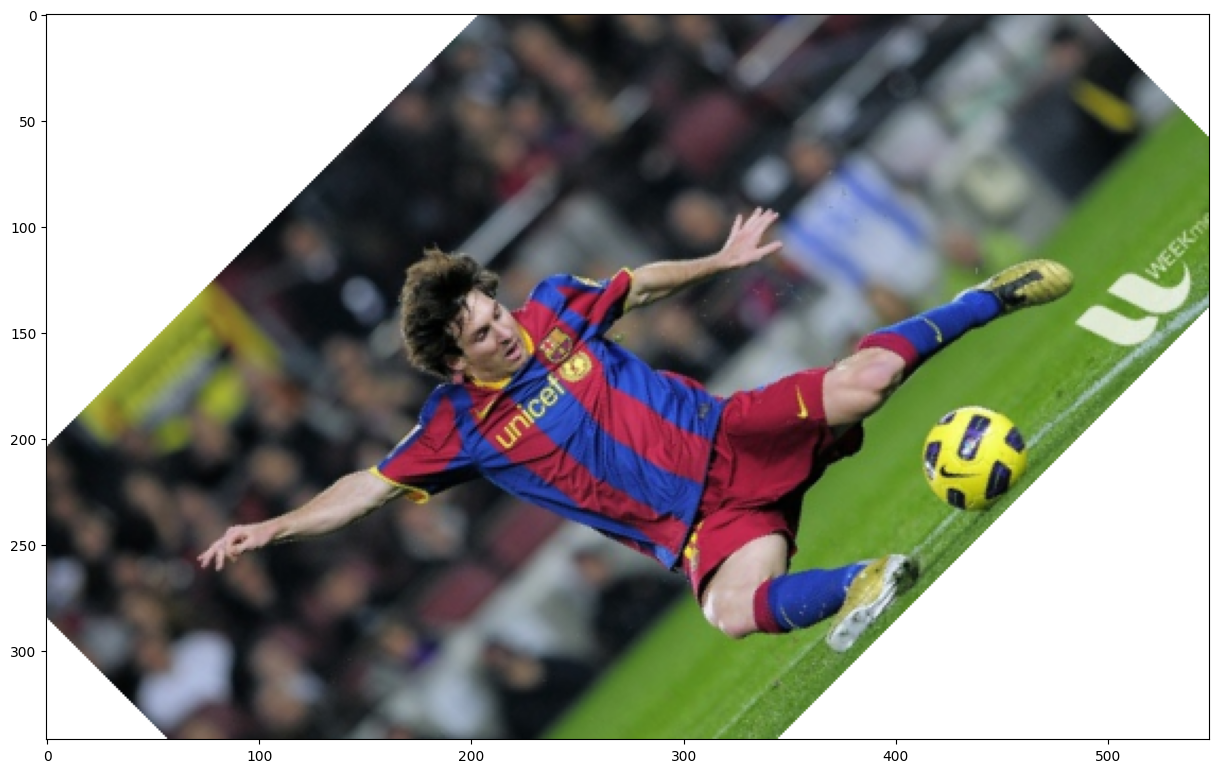

In [4]:
messi_alpha = cv2.cvtColor(messi, cv2.COLOR_RGB2RGBA)

rows, cols, chans = messi.shape

#specify our rotation in degrees
theta = 45.0

M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1) 
dst = cv2.warpAffine(messi_alpha,M,(cols,rows), borderMode=cv2.BORDER_TRANSPARENT)
                 
plt.figure()
plt.imshow(dst)

### General affine transform

Map 3 input (x,y) points to 3 output points (ie triangle to triangle)

Will perform translation, scaling, rotation, and skew, but not perspective correction

(<AxesSubplot:title={'center':'Output'}>,
 Text(0.5, 1.0, 'Output'))

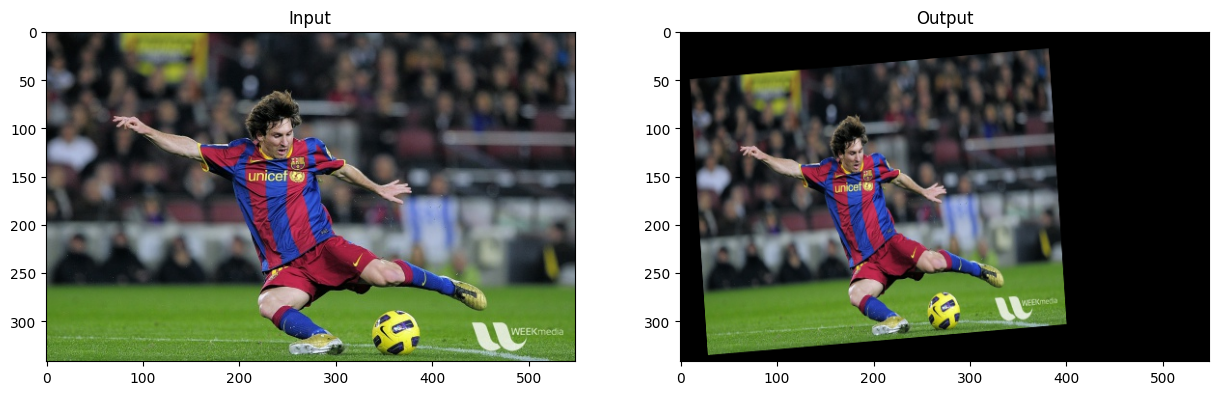

In [5]:
rows,cols,ch = messi.shape

pts1 = np.float32([[0,0],[0,cols],[rows,0]])
pts2 = np.float32([[10,50],[40,cols-40],[rows-100,30]])

M = cv2.getAffineTransform(pts1,pts2)

dst = cv2.warpAffine(messi,M,(cols,rows))

plt.figure()
plt.subplot(121),plt.imshow(messi),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

### Perspective transform

4 point transform

Nonlinear but more general than affine

Perspective:  further away objects look smaller

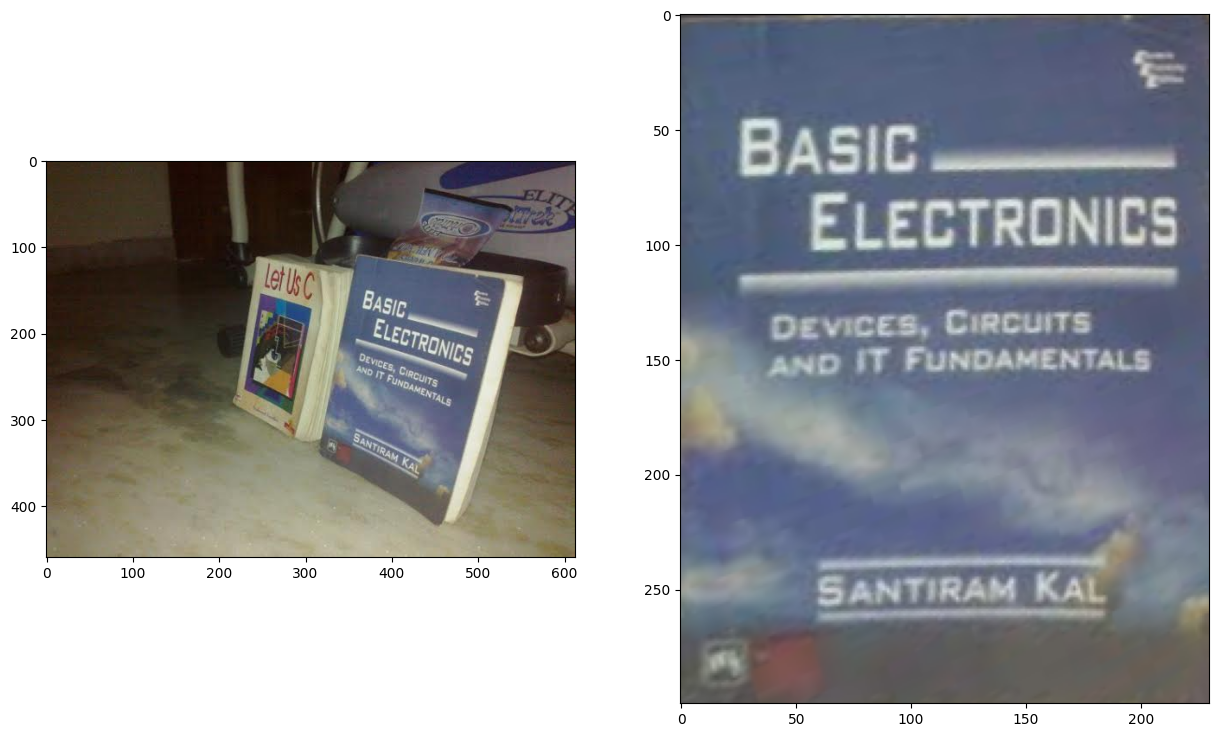

In [6]:
img = plt.imread('data/right.jpg')
rows,cols,chans = img.shape

startpts =  np.float32([[362, 107], [530,139] , [453,416], [319,337]])
endpts   =  np.float32([[100, 100], [330,100],  [330,400], [100,400]])

M = cv2.getPerspectiveTransform(startpts,endpts)

dst = cv2.warpPerspective(img, M, (rows,cols))

plt.figure()

plt.subplot(1,2,1)
plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(dst[100:400,100:330])

# Image compositing

### Combine images using a mask

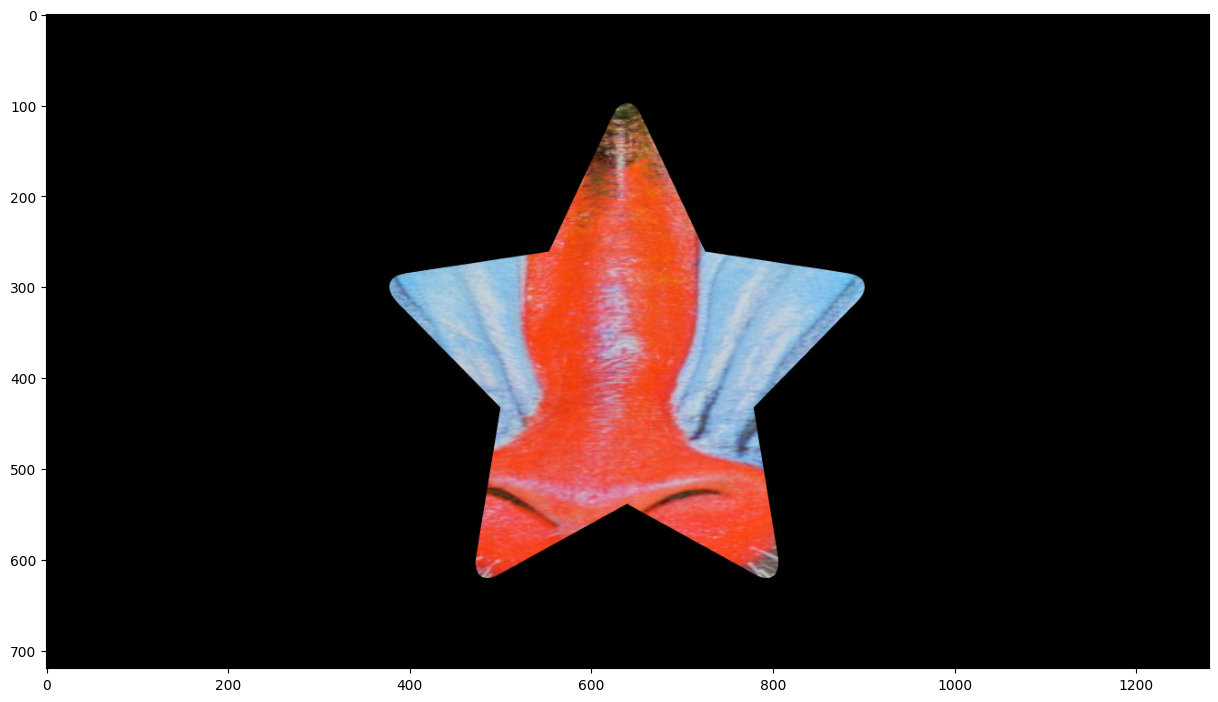

In [7]:
star_mask = plt.imread('data/star_mask.jpg').astype('float') / 255.

baboon = plt.imread('data/baboon.jpg').astype('float')
resized_baboon = cv2.resize(baboon, star_mask.shape[1::-1])

masked = (star_mask * resized_baboon).astype('uint8')

plt.figure()
plt.imshow(masked)


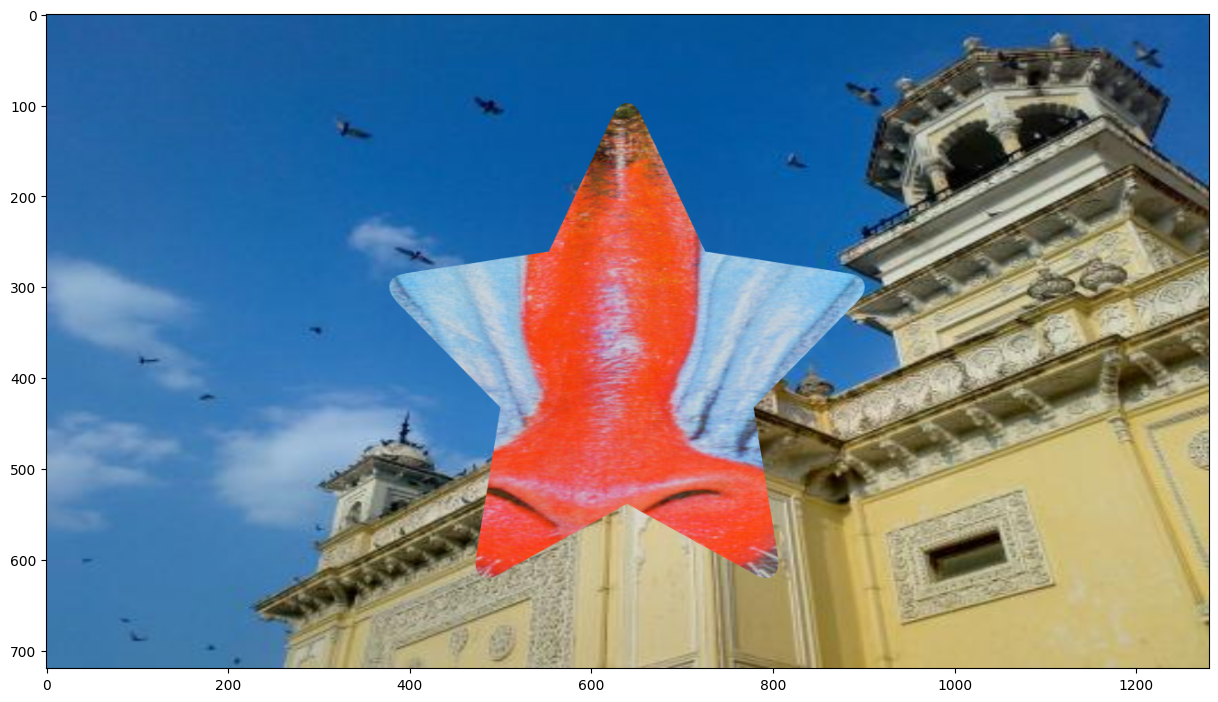

In [8]:
star_mask = plt.imread('data/star_mask.jpg').astype('float') / 255.

baboon = plt.imread('data/baboon.jpg').astype('float')
resized_baboon = cv2.resize(baboon, star_mask.shape[1::-1])

home = plt.imread('data/home.jpg').astype('float')
resized_home = cv2.resize(home, star_mask.shape[1::-1])

masked = (star_mask * resized_baboon + (1. - star_mask)*resized_home).astype('uint8')

plt.figure()
plt.imshow(masked)

### Seamless copy (advanced)

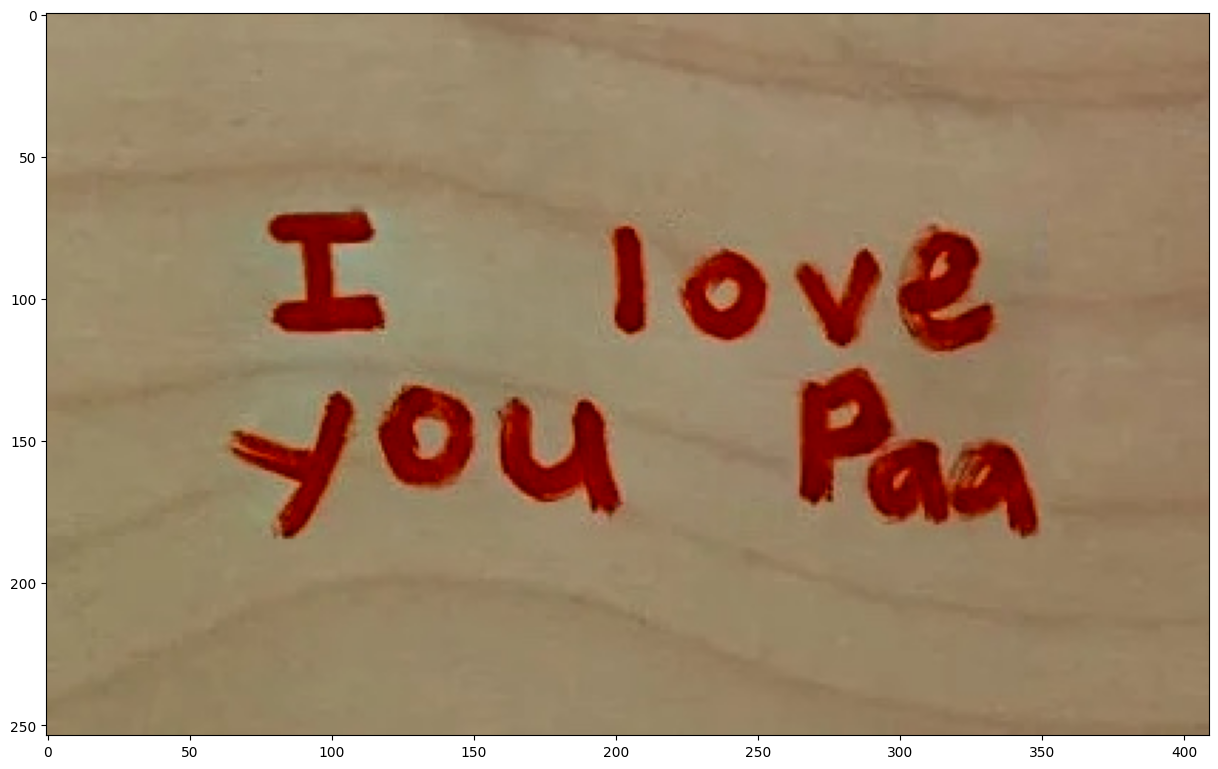

In [9]:
im = cv2.imread("data/wood-texture.jpg")


obj = cv2.imread("data/iloveyouticket.jpg")

mask = 255 * np.ones(obj.shape, obj.dtype)

width, height, channels = im.shape
center = (height//2, width//2)
    
seamless = cv2.seamlessClone(obj, im, mask, center, cv2.MIXED_CLONE)

plt.figure()
plt.imshow(cv2.cvtColor(seamless, cv2.COLOR_BGR2RGB))

## Mediapipe presentation

In [10]:
import mediapipe as mp

drawing_utils = mp.solutions.drawing_utils
drawing_styles = mp.solutions.drawing_styles

In [ ]:
def run_filter_with_mediapipe_model(mediapipe_model, mediapipe_based_filter):
    cap = cv2.VideoCapture(0)
    
    with mediapipe_model as model:
        while cap.isOpened():
            success, image = cap.read()

            if not success:
                print("Ignoring empty camera frame.")
                continue     # If loading a video, use 'break' instead of 'continue'.

            # Flip the image horizontally for a later selfie-view display, and convert
            # the BGR image to RGB.
            image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

            results = model.process(image)

            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            result_image = mediapipe_based_filter(image, results)

            cv2.imshow('MediaPipe', result_image)

            if cv2.waitKey(5) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    
    return image, results

### Holistic (Hands, Face and Pose tracking)

In [23]:
Holistic = mp.solutions.holistic.Holistic

In [24]:
def draw_holistic_results(image, results, show_hands=True, show_face=True, show_pose=False):
    if show_hands:
        drawing_utils.draw_landmarks(
            image,
            results.left_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

        drawing_utils.draw_landmarks(
            image,
            results.right_hand_landmarks,
            mp.solutions.holistic.HAND_CONNECTIONS,
            connection_drawing_spec=drawing_styles.get_default_hand_connections_style()
        )

    if show_face:
        drawing_utils.draw_landmarks(
            image,
            results.face_landmarks,
            mp.solutions.holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=drawing_utils.DrawingSpec(thickness=0, circle_radius=0, color=(255, 255, 255)),
            connection_drawing_spec=drawing_styles.get_default_face_mesh_contours_style()
        )

    if show_pose:
        drawing_utils.draw_landmarks(
            image,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=drawing_styles.get_default_pose_landmarks_style()
        )
    
    return image

In [25]:
holistic_model = Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [ ]:
last_image, last_results = run_filter_with_mediapipe_model(
    mediapipe_model=holistic_model,
    mediapipe_based_filter=draw_holistic_results
)